## a)Gráficas de la Interpolación Polinomial y Regresión

En este análisis, se generarán las gráficas de las siguentes interpoblaciones y regresines:
- Interpolación de Lagrange  
- Interpolación de Newton  
- Interpolación por Splines cúbicos  
- Regresiones: potencial

Se veran los diferentes métodos y se compararán los resultados para determinar la mejor aproximación a nuesta curva potencial de la Presion sobre el Volumen.

ºººººººººººººººººººººººººººººººººººººººººº
	Splines CUbicos
ºººººººººººººººººººººººººººººººººººººººººº
Temperatura: 200 K
Tramo 1:
S_0(x) = 4475915.8119(x - 0.65)^3 + 0.0000(x - 0.65)^2 + -5179036.6325(x - 0.65) + 5000000.0000
Tramo 2:
S_1(x) = -471370.1876(x - 0.85)^3 + 2685549.4871(x - 0.85)^2 + -4641926.7351(x - 0.85) + 4000000.0000
Tramo 3:
S_2(x) = -282967.7305(x - 1.1)^3 + 2332021.8464(x - 1.1)^2 + -3387533.9017(x - 1.1) + 3000000.0000
Tramo 4:
S_3(x) = -1353957.3988(x - 1.5)^3 + 1992460.5698(x - 1.5)^2 + -1657740.9352(x - 1.5) + 2000000.0000
Tramo 5:
S_4(x) = 135201.3081(x - 2.0)^3 + -38475.5284(x - 2.0)^2 + -680748.4145(x - 2.0) + 1500000.0000
Tramo 6:
S_5(x) = -86456.9394(x - 2.8)^3 + 286007.6111(x - 2.8)^2 + -482722.7483(x - 2.8) + 1000000.0000
Tramo 7:
S_6(x) = 7449.0623(x - 3.9)^3 + 699.7112(x - 3.9)^2 + -167344.6938(x - 3.9) + 700000.0000
Tramo 8:
S_7(x) = -3016.2017(x - 5.2)^3 + 29751.0543(x - 5.2)^2 + -127758.6986(x - 5.2) + 500000.0000
Tramo 9:
S_8(x) = -39.2207(x - 8.3

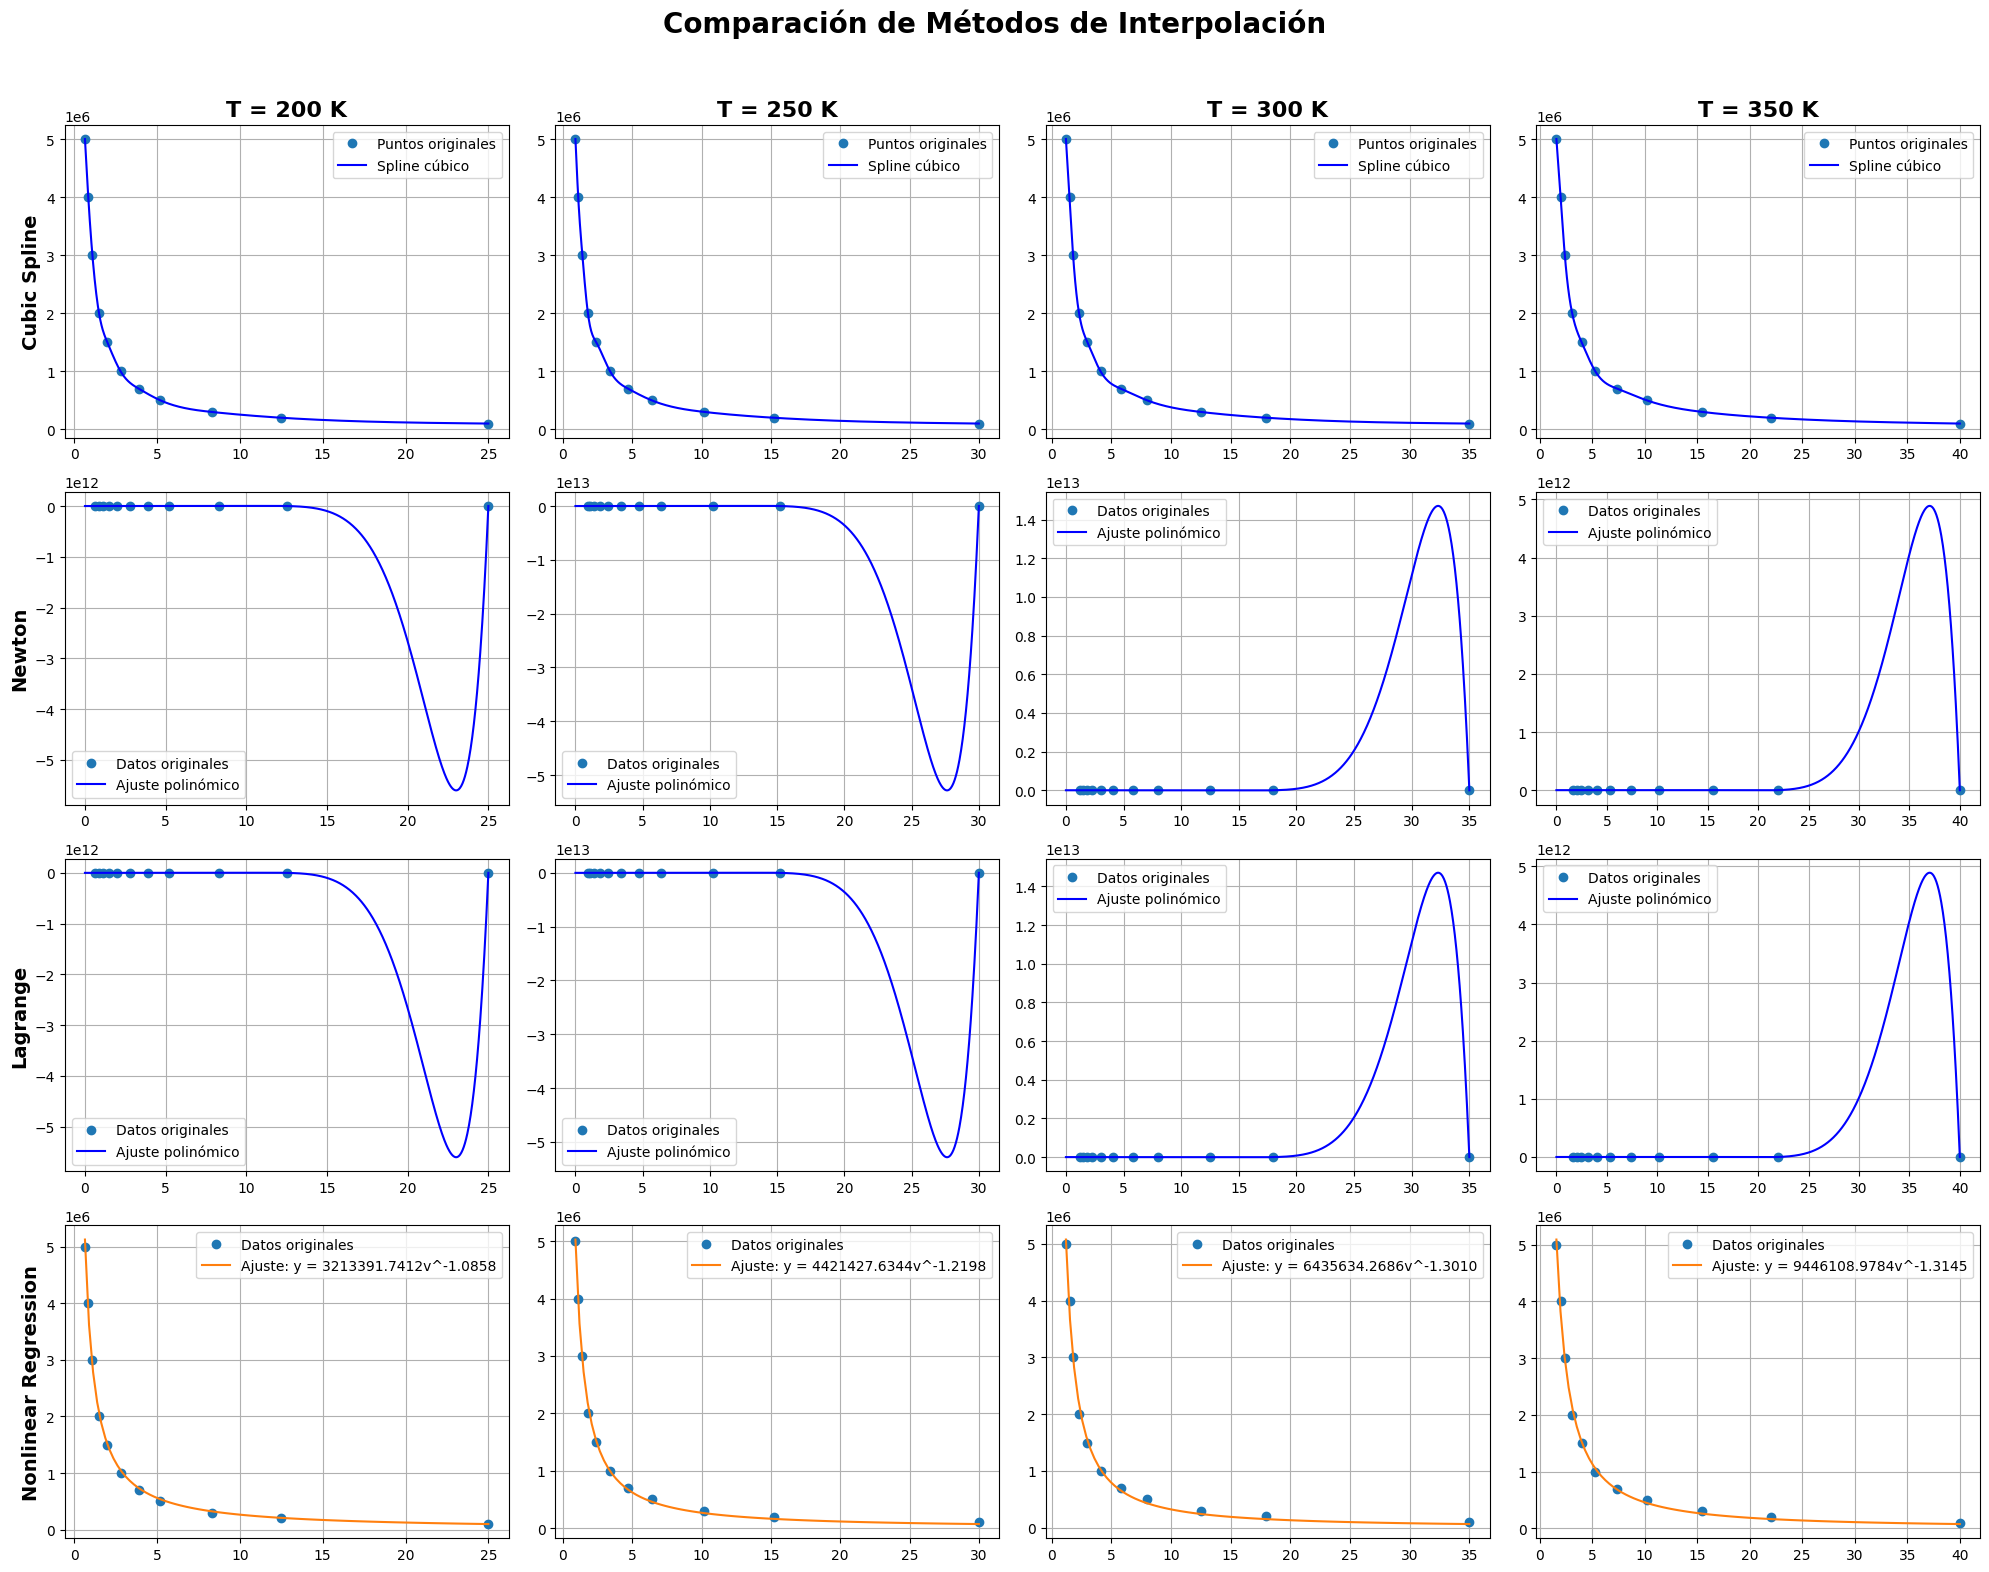

In [58]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import pandas as pd
from sympy import symbols, simplify, lambdify, prod
from scipy.optimize import curve_fit

class InterpolationPlotter:
    def __init__(self, df, columnas, temperaturas, P):
        self.df = df
        self.columnas = columnas
        self.temperaturas = temperaturas
        self.P = P * 1_000_000  # Convertir a Pa

    def cubic_spline(self, axs):
        print("ºººººººººººººººººººººººººººººººººººººººººº\n\tSplines CUbicos\nºººººººººººººººººººººººººººººººººººººººººº")
        for i, col in enumerate(self.columnas):
            V = np.array(self.df.iloc[2:14, col].dropna().astype(float).to_numpy())
            orden = np.argsort(V)
            V = V[orden]
            P_ordenada = self.P[orden]

            cs = CubicSpline(V, P_ordenada, bc_type='natural')
            x_fine = np.linspace(V.min(), V.max(), 1000)
            y_fine = cs(x_fine)
            A, B, C, D = cs.c
            
            print(f"Temperatura: {self.temperaturas[i]} K")
            for j in range(len(A)):
                print(f"Tramo {j + 1}:")
                print(f"S_{j}(x) = {A[j]:.4f}(x - {V[j]})^3 + {B[j]:.4f}(x - {V[j]})^2 + {C[j]:.4f}(x - {V[j]}) + {D[j]:.4f}")

            ax = axs[0, i]
            ax.plot(V, P_ordenada, 'o', label='Puntos originales')
            ax.plot(x_fine, y_fine, label='Spline cúbico', color='blue')
            ax.legend()
            ax.grid(True)

        axs[0, 0].set_ylabel('Cubic Spline', fontweight='bold', fontsize=14)

    def newton_interpolation(self, axs):
        def diferencias_divididas(x, y):
            n = len(y)
            coef = np.zeros([n, n])
            coef[:, 0] = y
            for j in range(1, n):
                for i in range(n - j):
                    coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) / (x[i + j] - x[i])
            return coef

        def construir_polinomio_simplificado(coef, x):
            x_sym = symbols('v')
            n = len(coef[0])
            polinomio = coef[0, 0]
            terminos = 1
            for i in range(1, n):
                terminos *= (x_sym - x[i - 1])
                polinomio += coef[0, i] * terminos
            return simplify(polinomio)
        print("****-------------------------------------------------****\n               INTERPOLACION DE NEWTON        \n****-------------------------------------------------****")
        for i, col in enumerate(self.columnas):
            V = np.array(self.df.iloc[2:14, col].dropna().astype(float).to_numpy())
            coef = diferencias_divididas(V, self.P)
            polinomio_simplificado = construir_polinomio_simplificado(coef, V)
            print(f"Temperatura {self.temperaturas[i]}°K:")
            print(f"{polinomio_simplificado}\n")
            p = lambdify(symbols('v'), polinomio_simplificado, modules=['numpy'])

            xp = np.linspace(0, np.max(V), 1000)
            ax = axs[1, i]
            ax.plot(V, self.P, 'o', label='Datos originales')
            ax.plot(xp, p(xp), color='blue', label='Ajuste polinómico')
            ax.legend()
            ax.grid(True)

        axs[1, 0].set_ylabel('Newton', fontweight='bold', fontsize=14)

    def lagrange_interpolation(self, axs):
        def lagrange_interpolation(x, y):
            x_sym = symbols('v')
            n = len(x)
            polinomio = 0
            for i in range(n):
                L_i = prod((x_sym - x[j]) / (x[i] - x[j]) for j in range(n) if j != i)
                polinomio += y[i] * L_i
            return simplify(polinomio)
        print("-------------------------------------------------\n               POLINOMIO DE LAGRANGE        \n-------------------------------------------------")

        for i, col in enumerate(self.columnas):
            V = np.array(self.df.iloc[2:14, col].dropna().astype(float).to_numpy())
            polinomio_simplificado = lagrange_interpolation(V, self.P)
            p = lambdify(symbols('v'), polinomio_simplificado, modules=['numpy'])
            print(f"Temperatura {self.temperaturas[i]}°K:")
            print(f"{polinomio_simplificado}\n")
            xp = np.linspace(0, np.max(V), 1000)
            ax = axs[2, i]
            ax.plot(V, self.P, 'o', label='Datos originales')
            ax.plot(xp, p(xp), color='blue', label='Ajuste polinómico')
            ax.legend()
            ax.grid(True)

        axs[2, 0].set_ylabel('Lagrange', fontweight='bold', fontsize=14)

    def nonlinear_regression(self, axs):
        def modelo(V, a, c):
            return a * V**c
        print("-------------------------------------------------\n               REGRESION POTENCIAL        \n-------------------------------------------------")
        for i, col in enumerate(self.columnas):
            V = np.array(self.df.iloc[2:14, col].dropna().astype(float).to_numpy())
            parametros, _ = curve_fit(modelo, V, self.P, p0=[2, 4])
            a, c = parametros
            P_predicho = modelo(V, a, c)
            rmse = np.sqrt(np.mean((self.P - P_predicho)**2))
            ss_res = np.sum((self.P - P_predicho)**2)
            ss_tot = np.sum((self.P - np.mean(self.P))**2)
            r2 = 1 - (ss_res / ss_tot)
            print(f"Temperatura {self.temperaturas[i]}°K:")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  R²: {r2:.4f}")
            print(f"  Ecuación ajustada: y = {a:.4f} * v^{c:.4f}\n")
            x_fine = np.linspace(min(V), max(V), 100)
            y_ajustado = modelo(x_fine, a, c)

            ax = axs[3, i]
            ax.plot(V, self.P, 'o', label='Datos originales')
            ax.plot(x_fine, y_ajustado, '-', label=f'Ajuste: y = {a:.4f}v^{c:.4f}')
            ax.legend()
            ax.grid(True)

        axs[3, 0].set_ylabel('Nonlinear Regression', fontweight='bold', fontsize=14)

    def plot_all_methods(self):
        fig, axs = plt.subplots(4, len(self.columnas), figsize=(20, 16))
        fig.suptitle('Comparación de Métodos de Interpolación', fontsize=20, fontweight='bold')

        self.cubic_spline(axs)
        self.newton_interpolation(axs)
        self.lagrange_interpolation(axs)
        self.nonlinear_regression(axs)

        for i, temp in enumerate(self.temperaturas):
            axs[0, i].set_title(f'T = {temp} K', fontweight='bold', fontsize=16)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

if __name__ == "__main__":
    # Ejemplo de uso de la clase InterpolationPlotter
    df = pd.read_excel("Caso_1.ods", sheet_name="Datos", engine="odf")
    columnas = [1, 4, 7, 10]
    temperaturas = [200, 250, 300, 350]
    P = np.array([0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2, 3, 4, 5])

    plotter = InterpolationPlotter(df, columnas, temperaturas, P)
    plotter.plot_all_methods()

## b) Polinomio de Hermite
Ahora vamos a representar V=f(T) pero considerando:
- dV/dT=0.0019 a una temperatura de 300ºK
- Presion es constante a 1000000 Pa

Tendriamos que hacerlo con los datos sobrayados en amarillo


_______________________________________________________________________________________

		Tabla de Diferencias Divididas para Hermite
_______________________________________________________________________________________

     0      1        2             3             4
0  2.8  0.012  0.00002  8.000000e-07 -5.333333e-09
1  3.4  0.014  0.00010  0.000000e+00  0.000000e+00
2  4.1  0.019  0.00010  0.000000e+00  0.000000e+00
3  4.1  0.024  0.00000  0.000000e+00  0.000000e+00
4  5.3  0.000  0.00000  0.000000e+00  0.000000e+00

///////////////////////////////////////////////////////////////////
	Polinomio de Interpolación de Hermite (Simplificado)
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

-5.33333333333334e-9*t**4 + 6.40000000000001e-6*t**3 - 0.00276666666666667*t**2 + 0.527000000000001*t - 34.6000000000001



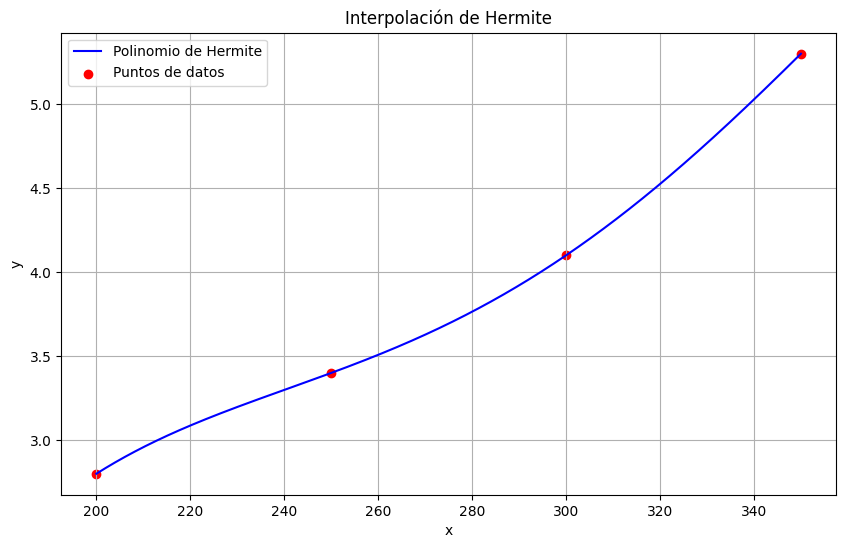

In [59]:
""""Hermite"""
import numpy as np
import pandas as pd
from sympy import symbols, simplify
import matplotlib.pyplot as plt

def diferencias_divididas_hermite(data_points, derivatives_info):
    """Calcula la tabla de diferencias divididas para interpolación de Hermite."""
    n = len(data_points)
    z = []
    Q = []
   
    for i, (xi, yi) in enumerate(data_points):
        z.append(xi)
        Q.append([yi])
       
        if xi in derivatives_info:
            z.append(xi)
            Q.append([yi])
            Q[-1].append(derivatives_info[xi])  # Primera derivada en puntos repetidos
            Q[-2].append((Q[-2][0] - Q[-3][0]) / (z[-2] - z[-3]) if len(Q) > 2 else derivatives_info[xi])
   
    # Inicializar la tabla de diferencias divididas con ceros
    m = len(z)
    for row in Q:
        while len(row) < m:
            row.append(0)
   
    # Calcular las diferencias divididas correctamente
    for j in range(1, m):
        for i in range(m - j):
            if j == 1 and z[i] == z[i + 1]:
                Q[i][j] = Q[i + 1][1]  # Usar la derivada cuando hay repetición del mismo x
            else:
                Q[i][j] = (Q[i + 1][j - 1] - Q[i][j - 1]) / (z[i + j] - z[i])
   
    return z, np.array(Q)
#PB
def construir_polinomio_simplificado_hermite(coef, t):
    """Construye y simplifica el polinomio de interpolación de Hermite."""
    x_sym = symbols('t')
    n = len(coef[0])
    polinomio = coef[0, 0]
    terminos = 1
    polinomio_expr = polinomio
   
    for i in range(1, n):
        terminos *= (x_sym - t[i - 1])
        polinomio_expr += coef[0, i] * terminos
   
    return simplify(polinomio_expr)

# Datos de ejemplo#(x,y)
data_points = [(200,2.8),(250,3.4),(300,4.1),(350,5.3)]
derivatives_info = {300:0.019}#en la tercera tupla tenemos una derivada  # Derivadas en algunos puntos

# Calcular la tabla de diferencias divididas para Hermite
z, tabla_coef_hermite = diferencias_divididas_hermite(data_points, derivatives_info)
tabla_df_hermite = pd.DataFrame(tabla_coef_hermite).fillna('')

# Calcular el polinomio simplificado
polinomio_simplificado_hermite = construir_polinomio_simplificado_hermite(tabla_coef_hermite, z)

# Mostrar la tabla y el polinomio simplificado
print("_______________________________________________________________________________________\n\n\t\tTabla de Diferencias Divididas para Hermite\n_______________________________________________________________________________________")
print(f"\n{tabla_df_hermite}\n")
print("///////////////////////////////////////////////////////////////////\n\tPolinomio de Interpolación de Hermite (Simplificado)\n\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")
print(f"\n{polinomio_simplificado_hermite}\n")

# Graficar el polinomio de Hermite
x_vals = np.linspace(min(z), max(z), 100000)#-100 200
hermite_func = lambdify(symbols('t'), polinomio_simplificado_hermite, modules=['numpy'])
y_vals = hermite_func(x_vals)
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label='Polinomio de Hermite', color='blue')
plt.scatter([point[0] for point in data_points], [point[1] for point in data_points], color='red', label='Puntos de datos')
plt.title('Interpolación de Hermite')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


## c) Vamos a ver si los Volumenes dados por el excel son iguales que los dados por la ecuacion de Peng-Robinson
- Para ello utilizamos metodos numericos para sacar los volumenes de la ecuacion de Peng-Robinso
- Esto lo haremos solo para una temperatura de 250K y con un error minimo de 0.001

### Utilizamos los siguientes metodos:
- Metodo de Newton-Raphson

En el word esta el analisis

In [60]:
import numpy as np
import pandas as pd
from sympy import symbols, simplify,diff,lambdify
import matplotlib.pyplot as plt
import math

V=symbols('v')
T=250
R=8.314
P= np.array([0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2, 3, 4, 5])*1_000_000#Pa
Tc=190.56
Pc=(4.59*1_000_000)
ω=0.011
Vc=98.6
a=0.4572*(((R**2)*(Tc**2))/(Pc))*(1+((0.37+(1.5*ω)-(0.26*(ω**2)))*(1-(math.sqrt(T/Tc)))))
b=0.077*((R*Tc)/(Pc))
# print(f"El valor de a es: {a}")
# print(f"El valor de b es: {b}")
def sacar(P,R,T,V,b,a):
    final=((R*T)/(V-b))-(a/(V**2 + 2*b*V - b**2))-P
    return simplify(final)
"""Metodo Newton-Raphson"""

def funciones(p):
    v=symbols('v')
    f_exp = sacar(p, R, T, v, b, a)
    df_exp = diff(f_exp, v)
    f = lambdify(v, f_exp, 'numpy')
    df = lambdify(v, df_exp, 'numpy')
    return f,df
# Método de Newton-Raphson
def newton_raphson_raiz(fx, dfx, x0, tolera, iteramax=500, precision=6):
    itera = 0
    tramo = float('inf')

    resultados = []

    while not (tramo < tolera or itera > iteramax):
        fx0 = fx(x0)
        dfx0 = dfx(x0)
        if np.abs(dfx0) < 1e-10:  # Umbral mínimo para evitar derivadas cercanas a cero
            print("Derivada demasiado pequeña. No se puede continuar.")
            return np.nan, pd.DataFrame(resultados)

        x1 = x0 - fx0 / dfx0
        tramo = np.abs(x1 - x0)

        resultados.append({
            "Iteración": itera,
            "x_i": np.round(x0, precision),
            "x_(i+1)": np.round(x1, precision),
            "f(x)": np.round(fx0, precision),
            "f'(x)": np.round(dfx0, precision),
            "Tramo": np.round(tramo, precision),
        })

        x0 = x1
        itera += 1
        
    if itera >= iteramax:
        x1 = np.nan
        print("No converge: se alcanzó el máximo de iteraciones.")

    tabla = pd.DataFrame(resultados)
    return x1, tabla

# Elegir un valor inicial para el volumen molar (v0)
df = pd.read_excel("Caso_1.ods", sheet_name="Datos", engine="odf")

# Tolerancia para la raíz
tolerancia = 1e-3
v0=((np.array(df.iloc[2:14, 4].dropna().astype(float).to_numpy()))*0.01604)
# Aplicar el método de Newton-Raphson para un valor de P

for i,p in enumerate(P):
    # Obtener las funciones f y f' para cada valor de P
    f,df=funciones(p)
    # Aplicar Newton-Raphson para encontrar la raíz
    raiz, tabla_resultados = newton_raphson_raiz(f, df, v0[i], tolerancia)
    
    # Mostrar la raíz encontrada y la tabla de resultados
    print(f"Raíz encontrada para P = {p/1_000_000}MPa :{raiz/0.01604} m^3/kg")#cambiamos de m^3/mol a m^3/kg 
    print(f"Numero de iteraciones de iteraciones: {len(tabla_resultados)}")

    # print(f"Iteración para presión {p / 1_000_000} MPa:\n{tabla_resultados}")
    # print(f(raiz))



Derivada demasiado pequeña. No se puede continuar.
Raíz encontrada para P = 0.1MPa :nan m^3/kg
Numero de iteraciones de iteraciones: 3
Derivada demasiado pequeña. No se puede continuar.
Raíz encontrada para P = 0.2MPa :nan m^3/kg
Numero de iteraciones de iteraciones: 3
Derivada demasiado pequeña. No se puede continuar.
Raíz encontrada para P = 0.3MPa :nan m^3/kg
Numero de iteraciones de iteraciones: 3
Derivada demasiado pequeña. No se puede continuar.
Raíz encontrada para P = 0.5MPa :nan m^3/kg
Numero de iteraciones de iteraciones: 3
Derivada demasiado pequeña. No se puede continuar.
Raíz encontrada para P = 0.7MPa :nan m^3/kg
Numero de iteraciones de iteraciones: 3
Derivada demasiado pequeña. No se puede continuar.
Raíz encontrada para P = 1.0MPa :nan m^3/kg
Numero de iteraciones de iteraciones: 3
Derivada demasiado pequeña. No se puede continuar.
Raíz encontrada para P = 1.5MPa :nan m^3/kg
Numero de iteraciones de iteraciones: 3
Derivada demasiado pequeña. No se puede continuar.
Raíz

## d)
El calculo de C(T) es muy complejo y se necesita experimentacio n. 
Con los datos del apartado b)  y considerando una presio n 
constante de 1 MPa determina a que T le corresponde un 
coeficiente del Virial de 6·10-4 m6/Kg2. Determinar el numero de 
iteraciones para un error de 0.01, 0.001 y de 10-10

_________________________________________________

	 Evalación de C(t)
_________________________________________________

 limite positivo en 0: -oo
 limite negativo en 0: oo
 limite de -inf: (1824677696700815480901202839527805456420954054934709332163*inf**12*exp(1131/inf**2) + 6568839708122921526128461406485850669284847025675124724952000*inf**11*exp(1131/inf**2) + 10722262315238124665034996368715318863783989601225911120563300000*inf**10*exp(1131/inf**2) + 10509114307347803376560138635394426111155010621973368129527600000000*inf**9*exp(1131/inf**2) + 6895846486352925749638856138014661523738190835221079067975610000000000*inf**8*exp(1131/inf**2) + 3192995599027955553408138787176505323586132434290418154820000000000000000*inf**7*exp(1131/inf**2) + 1069569406632326811448898045581989599192671590184773953874779000000000000000*inf**6*exp(1131/inf**2) + 260925536053080858271488259766751295381686324755300607951292000000000000000000*inf**5*exp(1131/inf**2) + 106666666666666800000000000000000000000

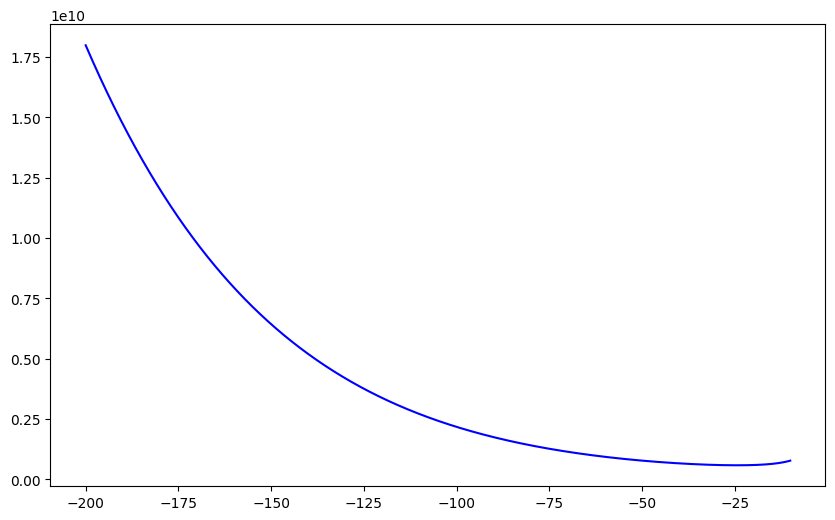

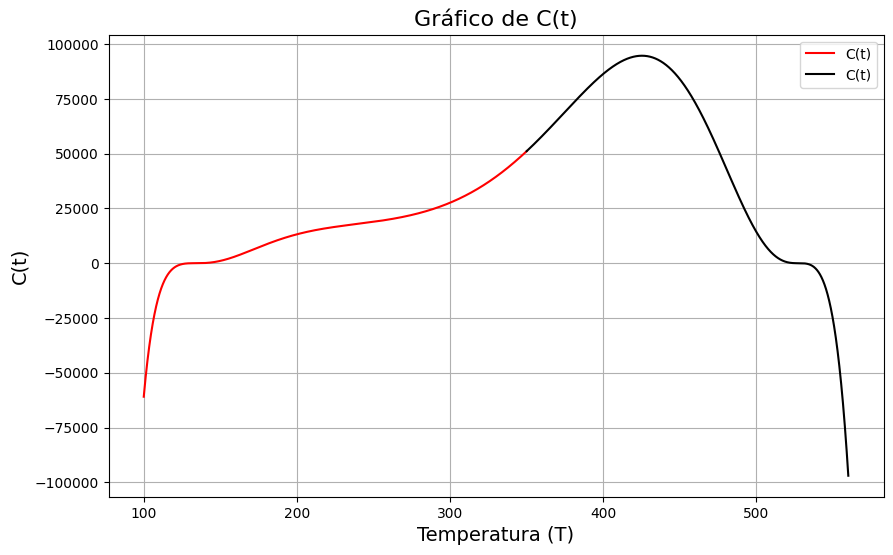

			     Resolucion Metodo de la secante	

     Tolerancia        Raíz  Iteraciones
0  1.000000e-02  133.867015           19
1  1.000000e-03  133.865847           21
2  1.000000e-10  133.865846           24
			     Resolucion Metodo de la BISECION	
     Tolerancia        Raíz  Iteraciones
0  1.000000e-02  133.874512           13
1  1.000000e-03  133.866882           16
2  1.000000e-10  133.865846           39


In [61]:
# V(t)(PV^2(t)/RT-V(t)-{[−0.199 + 0.20 · exp(−1131/T**2)]})=C(t)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import symbols, lambdify, simplify, exp
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

V=polinomio_simplificado_hermite
T=symbols('t')
P=1_000_000
R=8.314
lista_C_r=[6e-4,1e-4,8.5e-4]

C_r=lista_C_r[0]
V_numeric = lambdify(T, polinomio_simplificado_hermite, modules=['numpy'])
def mandar(V,P,T,R,C_r):
    """Calcula el valor de C(t) para un conjunto de datos."""
    C_t = (((P * V**3) / (R * T)) - (V**2) - ((-0.199 + 0.20 *exp(-1131 / T**2))*V))
    return simplify(C_t-C_r),simplify(C_t)
func_expr,c_t = mandar(V,P,T,R,C_r)
func_numeric = lambdify(T, func_expr, modules=['numpy'])

"""Evaluacion de limites"""
c_p=sp.limit(c_t,T,0,dir="+")
c_n=sp.limit(c_t,T,0,dir="-")
sef_p=sp.limit(c_t,T,"+inf")
sef_n=sp.limit(c_t,T,"-inf")
print("_________________________________________________\n\n\t Evalación de C(t)\n_________________________________________________")
print(f"\n limite positivo en 0: {c_p}\n limite negativo en 0: {c_n}\n limite de -inf: {sef_n}\n limite de inf: {sef_p}\n")


# 100,300
# Generar valores de T para graficar 560
T_vals_N = np.linspace(-200, -10, 10000)
T_vals_P = np.linspace(100,350,10000)
T_vals_P1 = np.linspace(350,560,10000)
C_vals_N = func_numeric(T_vals_N)
C_vals_P = func_numeric(T_vals_P)
C_vals_P1 = func_numeric(T_vals_P1)
# Graficar la función
plt.figure(figsize=(10, 6))
plt.plot(T_vals_N, C_vals_N, label='C(t)', color='blue')#quei vemos como van los valores negativos y vemos que va a ser C(t)>0
"""
Ahora tenemos que ver que pasa en la parte positiva
"""
plt.figure(figsize=(10, 6))
plt.plot(T_vals_P, C_vals_P, label='C(t)', color='red')
plt.plot(T_vals_P1, C_vals_P1, label='C(t)', color='black')
plt.title('Gráfico de C(t)', fontsize=16)
plt.xlabel('Temperatura (T)', fontsize=14)
plt.ylabel('C(t)', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

a = 100
b = 200
""""
Metodo Secante
"""
def secante_raiz(fx, a, b, tolera, iteramax=100, precision=6):
    
    xi_1 = a
    xi = b
    itera = 0
    tramo = np.abs(xi - xi_1)

    # Almacenar resultados para la tabla
    resultados = []

    while not (tramo < tolera or itera > iteramax):
        fi_1 = fx(xi_1)
        fi = fx(xi)
        xi1 = xi - fi * (xi_1 - xi) / (fi_1 - fi)
        tramo = np.abs(xi1 - xi)

        resultados.append({
            "Iteración": itera,
            "x[i-1]": round(xi_1, precision),
            "x[i]": round(xi, precision),
            "x[i+1]": round(xi1, precision),
            "f(x[i-1])": round(fi_1, precision),
            "f(x[i])": round(fi, precision),
            "Tramo": round(tramo, precision),
        })

        xi_1 = xi
        xi = xi1
        itera += 1

    # Verificar convergencia
    if itera >= iteramax:
        xi = np.nan
        print("No converge: se alcanzó el máximo de iteraciones.")

    # Crear tabla
    tabla = pd.DataFrame(resultados)

    return xi, tabla

def graficar_secante(fx, a, b, tabla, tolera):

    x = np.linspace(a - 1, b + 1, 500)
    y = fx(x)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='f(x)', color='blue')
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

    # Graficar las secantes
    for i in range(len(tabla) - 1):
        x_secante = [tabla.loc[i, "x[i-1]"], tabla.loc[i, "x[i]"]]
        y_secante = [tabla.loc[i, "f(x[i-1])"], tabla.loc[i, "f(x[i])"]]
        plt.plot(x_secante, y_secante, linestyle='--', marker='o', label=f'Secante {i+1}')

    # Marcar la raíz final
    raiz = tabla.iloc[-1]["x[i+1]"]
    plt.plot(raiz, fx(raiz), 'ro', label='Raíz aproximada')

    plt.title('Método de la Secante')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend()
    plt.grid(True)
    plt.show()



print("============================================================================================\n\t\t\t     Resolucion Metodo de la secante\t\n============================================================================================")

# Valores iniciales y parámetros
# tolera = 1e-10
lista_tolerancia = [0.01, 0.001, 1e-10]
# PROCEDIMIENTO
resutar=[]
for tolera in lista_tolerancia:
    # print(f"Tolerancia: {tolera}")
    respuesta, tabla = secante_raiz(func_numeric, a, b, tolera, iteramax=100, precision=6)
    # print(f'Raíz aproximada: {respuesta}')
    # print(f"Numerodo de iteraciones: {len(tabla)}\n")
    resutar.append((tolera,respuesta,len(tabla)))
    # print("\nTabla de Iteraciones:")
    # print(tabla)
df_resutar=pd.DataFrame(resutar, columns=["Tolerancia", "Raíz", "Iteraciones"])
print(f"\n{df_resutar}")
# print(f"Nada lo que se dibujo\n\n{tabla}")
# graficar_secante(func_numeric, a, b, tabla, tolera)

"""
Metodo de la bisection
"""

def bisection_method_numeric(func, a, b, tol):
    iterations = []
    if func(a) * func(b) >= 0:
        raise ValueError("func(a) y func(b) deben tener signos opuestos")
    
    while (b - a) / 2 > tol:
        c = (a + b) / 2
        error = (b - a) / 2
        iterations.append((a, b, c, func(a), func(b), func(c), error))
        if func(c) == 0:
            break
        elif func(a) * func(c) < 0:
            b = c
        else:
            a = c
    return c, iterations
print("============================================================================================\n\t\t\t     Resolucion Metodo de la BISECION\t\n============================================================================================")

lista_tolerancia = [0.01, 0.001, 1e-10]
resultar = []

# Ejecutar el método de bisección para cada tolerancia
for tol in lista_tolerancia:
    root_bisection_numeric, iterations_bisection_numeric = bisection_method_numeric(func_numeric, a, b, tol)
    resultar.append((tol, root_bisection_numeric, len(iterations_bisection_numeric)))
    columns = ["a", "b", "c", "func(a)", "func(b)", "func(c)", "error"]
    # Crear una tabla con las iteraciones
    # iteration_df_numeric = pd.DataFrame(iterations_bisection_numeric, columns=columns)
    # # Mostrar tabla
    # print("Tabla de Iteraciones del Método de Bisección para func_numeric:")
    # print(iteration_df_numeric)
    # Crear un DataFrame con los resultados
resultar_df = pd.DataFrame(resultar, columns=["Tolerancia", "Raíz", "Iteraciones"])

# Mostrar los resultados
print(resultar_df)

# Crear una tabla con las iteraciones
# iteration_df_numeric = pd.DataFrame(iterations_bisection_numeric, columns=columns)

# # Mostrar tabla
# print("Tabla de Iteraciones del Método de Bisección para func_numeric:")
# print(iteration_df_numeric)

# Gráfica de la función y las raíces
# x_vals_numeric = np.linspace(a, b, 400)
# y_vals_numeric = func_numeric(x_vals_numeric)

# plt.figure(figsize=(10, 6))
# plt.plot(x_vals_numeric, y_vals_numeric, label="func_numeric(T)", color="blue")
# plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

# # Mostrar raíz encontrada
# plt.scatter(root_bisection_numeric, 0, color="red", label="Bisección (func_numeric)")

# # Formateo de ejes
# plt.xlabel("T", fontsize=12)
# plt.ylabel("func_numeric(T)", fontsize=12)
# plt.title("Búsqueda de Raíz por Método de Bisección (func_numeric)", fontsize=14)
# plt.legend()
# plt.grid(True)
# plt.show()






## d) Calculamos los valores de T para los siguentes coeficientes virales
- 6x10^-4 Calculamos para un error de 0.001
- 8.5x10^-4 Calculamos para un error de 0.001
- Luego *graficamos la curva del coeficiente Viral **C(T)*** con los mismos metodos del apartado a)

Utilizaremos el **Metodo de la secante** ya que se necesita menos iteraciones para encontrar la raiz

Raíz aproximada para el coeficiente del Virial de 0.0001 es : 133.81085991646987
 Numero iteraciones 23

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Raíz aproximada para el coeficiente del Virial de 0.00085 es : 133.8801536284601
 Numero iteraciones 20

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


ºººººººººººººººººººººººººººººººººººººººººº
	Splines CUbicos
ºººººººººººººººººººººººººººººººººººººººººº
Tramo 1:
S_0(x) = 1.0998(x - 133.81085991646987)^3 + 0.0000(x - 133.81085991646987)^2 + 0.0058(x - 133.81085991646987) + 0.0001
Tramo 2:
S_1(x) = -4.2270(x - 133.86584675229554)^3 + 0.1814(x - 133.86584675229554)^2 + 0.0157(x - 133.86584675229554) + 0.0006

****-------------------------------------------------****
               INTERPOLACION DE NEWTON        
****-------------------------------------------------****
0.120949351585802*x**2 - 32.3662310207017*x + 2165.31328850571


----

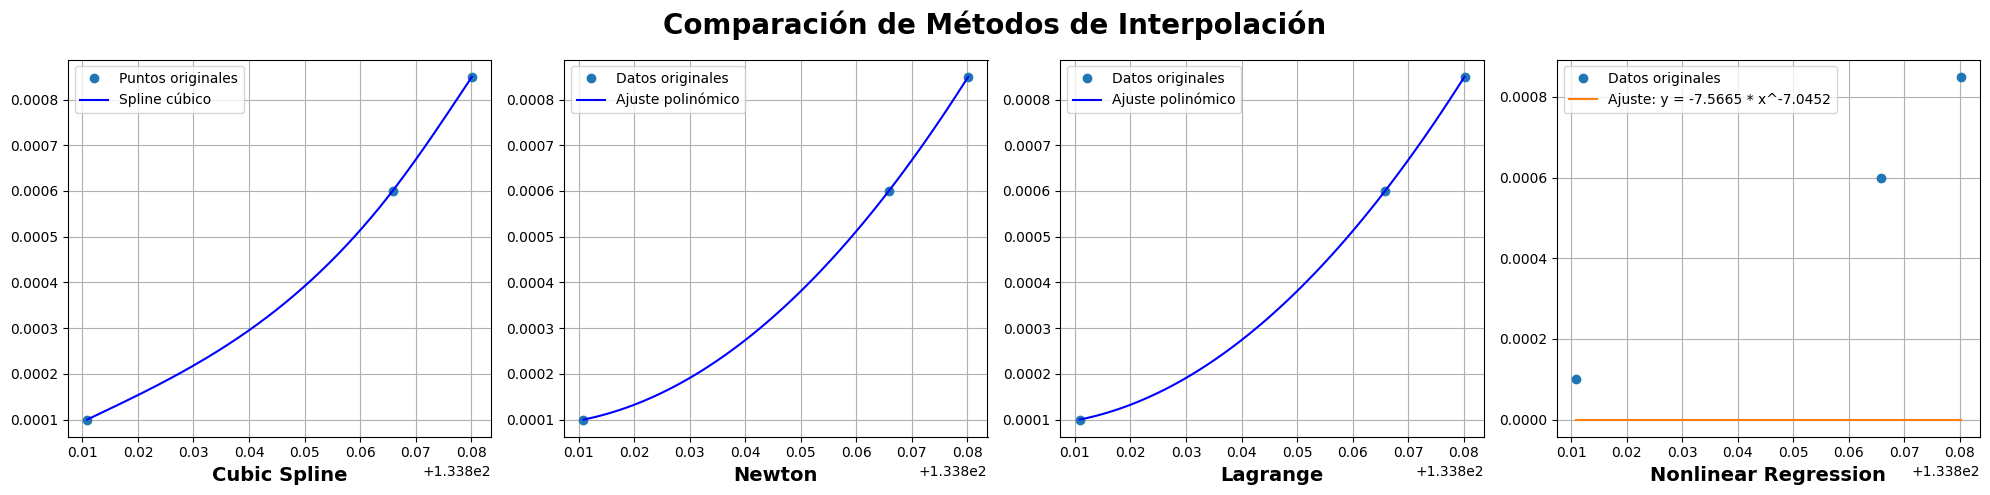

In [62]:
""" Aqui calculamos el resto de puntos """
temper=[]
for i, C_r_i in enumerate(lista_C_r):
    if i == 0:  # Saltar el primer valor (C_r[0]) porqie ya lo hicimos en aparte anterior
        func_expr,_ = mandar(V, P, T, R, C_r_i)
        func_numeric = lambdify(T, func_expr, modules=['numpy'])
        tol=0.001
        raiz_secante, tabla = secante_raiz(func_numeric, a, b, tol)
        temper.append(raiz_secante)
        continue
    func_expr,_ = mandar(V, P, T, R, C_r_i)
    func_numeric = lambdify(T, func_expr, modules=['numpy'])
    tol=0.001
    raiz_secante, tabla = secante_raiz(func_numeric, a, b, tol)
    print(f"Raíz aproximada para el coeficiente del Virial de {lista_C_r[i]} es : {raiz_secante}\n Numero iteraciones {len(tabla)}")
    print(f"\n||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||\n")
    temper.append(raiz_secante)
""" Aqui tenemos las grficas """
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import pandas as pd
from sympy import symbols, simplify, lambdify, prod
from scipy.optimize import curve_fit

class InterpolationPlotter:
    def __init__(self, temperaturas, C):
        self.temperaturas = temperaturas# temperatura constante
        self.C = C  # Convertir a Pa

    def cubic_spline(self, ax):
        print("\nºººººººººººººººººººººººººººººººººººººººººº\n\tSplines CUbicos\nºººººººººººººººººººººººººººººººººººººººººº")

        T=self.temperaturas
        orden = np.argsort(T)

        T = T[orden]

        C_ordenada = self.C[orden]

        cs = CubicSpline(T, C_ordenada, bc_type='natural')
        x_fine = np.linspace(T.min(), T.max(), 1000)
        y_fine = cs(x_fine)
        A, B, C, D = cs.c
        for j in range(len(A)):
            print(f"Tramo {j + 1}:")
            print(f"S_{j}(x) = {A[j]:.4f}(x - {T[j]})^3 + {B[j]:.4f}(x - {T[j]})^2 + {C[j]:.4f}(x - {T[j]}) + {D[j]:.4f}")

        ax.plot(T, C_ordenada, 'o', label='Puntos originales')
        ax.plot(x_fine, y_fine, label='Spline cúbico', color='blue')
        ax.legend()
        ax.grid(True)

        ax.set_xlabel('Cubic Spline', fontweight='bold', fontsize=14)

    def newton_interpolation(self, ax):
        def diferencias_divididas(x, y):
            n = len(y)
            coef = np.zeros([n, n])
            coef[:, 0] = y
            for j in range(1, n):
                for i in range(n - j):
                    coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) / (x[i + j] - x[i])
            return coef

        def construir_polinomio_simplificado(coef, x):
            x_sym = symbols('x')
            n = len(coef[0])
            polinomio = coef[0, 0]
            terminos = 1
            for i in range(1, n):
                terminos *= (x_sym - x[i - 1])
                polinomio += coef[0, i] * terminos
            return simplify(polinomio)
        print("\n****-------------------------------------------------****\n               INTERPOLACION DE NEWTON        \n****-------------------------------------------------****")
        T=self.temperaturas
        coef = diferencias_divididas(T, self.C)
        polinomio_simplificado = construir_polinomio_simplificado(coef, T)
        print(f"{polinomio_simplificado}\n")
        p = lambdify(symbols('x'), polinomio_simplificado, modules=['numpy'])

        xp = np.linspace(min(T), max(T), 100)


        ax.plot(T, self.C, 'o', label='Datos originales')
        ax.plot(xp, p(xp), color='blue', label='Ajuste polinómico')
        ax.legend()
        ax.grid(True)

        ax.set_xlabel('Newton', fontweight='bold', fontsize=14)

    def lagrange_interpolation(self, ax):
        def lagrange_interpolation(x, y):
            x_sym = symbols('x')
            n = len(x)
            polinomio = 0
            for i in range(n):
                L_i = prod((x_sym - x[j]) / (x[i] - x[j]) for j in range(n) if j != i)
                polinomio += y[i] * L_i
            return simplify(polinomio)
        print("\n-------------------------------------------------\n               POLINOMIO DE LAGRANGE        \n-------------------------------------------------")

        T=self.temperaturas
        polinomio_simplificado = lagrange_interpolation(T, self.C)
        p = lambdify(symbols('x'), polinomio_simplificado, modules=['numpy'])
        print(f"{polinomio_simplificado}\n")
        xp = np.linspace(min(T), max(T), 100)


        ax.plot(T, self.C, 'o', label='Datos originales')
        ax.plot(xp, p(xp), color='blue', label='Ajuste polinómico')
        ax.legend()
        ax.grid(True)

        ax.set_xlabel('Lagrange', fontweight='bold', fontsize=14)

    def nonlinear_regression(self, ax):
        def modelo(V, a, c):
            return a * V**c
        print("\n-------------------------------------------------\n               REGRESION POTENCIAL        \n-------------------------------------------------")
        T=self.temperaturas
        parametros, _ = curve_fit(modelo, T, self.C, p0=[1,1],maxfev=100000)
        a, c = parametros
        P_predicho = modelo(T, a, c)
        rmse = np.sqrt(np.mean((self.C - P_predicho)**2))
        ss_res = np.sum((self.C - P_predicho)**2)
        ss_tot = np.sum((self.C - np.mean(self.C))**2)
        r2 = 1 - (ss_res / ss_tot)
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²: {r2:.4f}")
        print(f"  Ecuación ajustada: y = {a:.4f} * x^{c:.4f}\n")
        x_fine = np.linspace(min(T), max(T), 100)
        y_ajustado = modelo(x_fine, a, c)

        ax.plot(T, self.C, 'o', label='Datos originales')
        ax.plot(x_fine, y_ajustado, '-', label=f'Ajuste: y = {a:.4f} * x^{c:.4f}')
        ax.legend()
        ax.grid(True)

        ax.set_xlabel('Nonlinear Regression', fontweight='bold', fontsize=14)

    def plot_all_methods(self):
        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        fig.suptitle('Comparación de Métodos de Interpolación', fontsize=20, fontweight='bold')

        self.cubic_spline(ax[0])
        self.newton_interpolation(ax[1])
        self.lagrange_interpolation(ax[2])
        self.nonlinear_regression(ax[3])
        plt.tight_layout()
        plt.show()
if __name__ == "__main__":
    # Ejemplo de uso de la clase InterpolationPlotter
    temperaturas =np.array(temper)
    C = np.array([6e-4,1e-4,8.5e-4])

    plotter = InterpolationPlotter(temperaturas, C)
    plotter.plot_all_methods()
#x-->t